In [1]:
from mssa.mssa import mSSA
import pandas as pd 
import matplotlib.pyplot as plt 
import io
import numpy as np 
import torch 
import copy 
from sklearn.metrics import r2_score
import os 
from datetime import datetime, timedelta
from datetime import timedelta
dev = False

In [2]:
file = "traffic.txt"
isExist = os.path.exists(file)
if not isExist:
    print(f"Files not exist")

In [3]:
"""Preprocess data"""
data = pd.read_csv('traffic.txt', delimiter = ',', header=None)
print('data loaded..')
data_2 = data.copy()
#pick the first 20 clients
data_2 = data_2.iloc[:,:20]
#create time column: 2 years 1 hour
data_2['time'] = pd.to_datetime(np.arange(datetime(2015,1,1), datetime(2017,1,1), timedelta(hours=1)))
data_2.index = data_2['time']
data_2 = data_2.drop(['time'], axis = 1)
#create column names
data_3 = data_2.copy()
col_names = ['MT_{0:03}'.format(i+1) for i in range(data_3.shape[1])]
data_3.columns = col_names
aggregated_data = data_3.copy()

data loaded..


In [4]:
aggregated_data.shape

(17544, 20)

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [6]:
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,-0.936348,-1.154807,-0.569033,-0.500971,-0.765328,-0.665566,-0.660995,-0.414196,-0.822551,-0.854473,-0.914064,-0.568700,-0.899862,-0.569866,-1.335692,-0.748872,-0.798016,-0.608055
2015-01-01 01:00:00,-0.674341,-0.645010,-0.862140,-1.067719,-0.513278,-0.488945,-0.701394,-0.490022,-0.447094,-0.407787,-0.770593,-0.822892,-0.849406,-0.507760,-0.835587,0.155680,-1.213432,-0.748872,-0.514071,-0.599583
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,-0.610849,-0.594173,-0.822705,-0.641794,-0.681695,-0.484698,-0.886055,-0.901844,-0.951011,-0.735623,-1.053028,-0.145701,-1.310521,-0.952812,-0.716423,-0.691364
2015-01-01 03:00:00,-0.727168,-0.826841,-1.022720,-1.296324,-0.666604,-0.672342,-0.886640,-0.810024,-0.959996,-0.602201,-1.015951,-0.929478,-1.023059,-0.923742,-1.177476,-0.839993,-1.321309,-1.093459,-0.977522,-0.729489
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,-0.573359,-1.079455,-0.943294,-1.041533,-1.045622,-1.233545,-1.221742,-1.342884,-1.130380,-1.170083,-0.753493


In [7]:
if dev:
    cols = normalized_data.columns

In [8]:
if dev:
    test_df = normalized_data.iloc[:5][cols[:5]].copy()
    np_test = test_df.to_numpy()

In [9]:
if dev:
    """Inject missing data"""
    # Convert original data to 1d array - Because existing package only supports randomly choose from 1d array
    np_test_1d = np_test.flatten()
    np_test_1d

In [10]:
if dev:
    total_elem = np_test_1d.shape[0]
    missing_percentage = 50
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100) 
    print(number_of_missing_elem)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False)
    np_test_1d[missing_index] = 0
    np_test_1d

In [11]:
if dev:
    np_test_2d = np_test_1d.reshape(5,-1)
    np_test_2d

In [12]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    if missing_percentage == 0: return pd_data
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports to randomly choose indices from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,0.000000,-1.154807,0.000000,-0.500971,-0.765328,-0.665566,0.000000,-0.414196,-0.822551,-0.854473,0.000000,0.000000,-0.899862,-0.569866,-1.335692,-0.748872,-0.798016,-0.608055
2015-01-01 01:00:00,-0.674341,-0.645010,-0.862140,-1.067719,-0.513278,0.000000,-0.701394,-0.490022,-0.447094,0.000000,-0.770593,-0.822892,-0.849406,-0.507760,-0.835587,0.155680,-1.213432,0.000000,0.000000,-0.599583
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,-0.610849,-0.594173,-0.822705,-0.641794,-0.681695,-0.484698,-0.886055,0.000000,-0.951011,-0.735623,-1.053028,-0.145701,-1.310521,-0.952812,-0.716423,-0.691364
2015-01-01 03:00:00,-0.727168,0.000000,-1.022720,-1.296324,-0.666604,0.000000,-0.886640,0.000000,0.000000,-0.602201,-1.015951,-0.929478,-1.023059,0.000000,-1.177476,-0.839993,0.000000,-1.093459,-0.977522,-0.729489
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,-0.573359,-1.079455,-0.943294,-1.041533,-1.045622,0.000000,-1.221742,-1.342884,-1.130380,-1.170083,-0.753493


In [13]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:17376,:n_clients] 
    data_test = normalized_data.iloc[17376:,:n_clients]
    return data_train, data_test

In [14]:
data_train, data_test = set_train_test(n_clients=20)
print(data_train.shape)
print(data_test.shape)

(17376, 20)
(168, 20)


In [15]:
def get_flattened_obs(data_train, L=80):
    df = data_train
    N = df.shape[1]
#     col_to_row_ratio = 4

    T = df.shape[0]

    M = int(df.size / L)
    if M%N != 0:
        M -= M%N
    M_ts = M // N
    # inc_obs = np.array(df.iloc[:M_ts*L,:]) # first range, we use second range for traning
    inc_obs = np.array(df.iloc[T%L:,:]) # second range, note its not T%L+1 due to python index
    normalize = False
    from sklearn.preprocessing import StandardScaler
    if normalize:
        scaler = StandardScaler()
        inc_obs = scaler.fit_transform(inc_obs)
        norm_means = scaler.mean_
        norm_std = scaler.scale_

    flattened_obs = inc_obs.reshape([L,M], order = 'F') # 按照列顺序
    # flattened_obs = flattened_obs[:,np.arange(M_ts*self.no_ts).reshape([self.no_ts,M_ts]).flatten('F')] # 这里导致第二列是ts2，stacked page是不同ts交错组成
    return flattened_obs, M_ts

In [16]:
global N; global M_ts; global L; global window
L = 100
flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
window = M_ts

In [17]:
def predict_one_day(data_test, model, weights, days=7):
    # predict for seven days
    # days = 7

    #initialise prediction array
    predictions = np.zeros((len(data_test.columns),24*days))
    ub = np.zeros((len(data_test.columns),24*days))
    lb = np.zeros((len(data_test.columns),24*days))

    # specify start time
    start_time = pd.Timestamp('2016-12-25 00:00:00')

    # actual = data_test.values[:24*days,:]

    # obtain new actual by index, new test start from 2014-12-02-17:00
    actual = data_test[data_test.index>=start_time].values[:24*days,:]


    for day in range(days):
        # get the final time stamp in the day
        end_time = start_time + pd.Timedelta(hours=23)
        # convert timestamps to string
        start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
        end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
        # predict for each house
        for i, column in enumerate(data_test.columns):
            # Forecast
            df_30 = model.predict(column,start_str,end_str)
            predictions[i,day*24:(day+1)*24] = df_30['Mean Predictions']
            ub[i,day*24:(day+1)*24] = df_30['Upper Bound']
            lb[i,day*24:(day+1)*24] = df_30['Lower Bound']

        # fit the model with the already predicted values 

        # df_insert = data_test.iloc[day*24:24*(day+1),:]

        # obtain new df_insert
        # df_insert = data_test[data_test.index>=start_time].iloc[day*24:24*(day+1),:]

        # model.update_model(df_insert)
    
        if weights is not None:
            model.ts_model.models[0].weights = weights

        # update start_time
        start_time = start_time + pd.Timedelta(hours=24)
    return actual, predictions

In [18]:
def test_sd(data_train, data_test, L, n_users, M_ts, dim, days, plot_all, plot_single):
    data_train = data_train.iloc[:,:n_users] # Debug1
    data_test = data_test.iloc[:,:n_users]

    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
    # stand-alone ssa
    window = M_ts
    lst_U_sd = []
    for i in range(n_users):
        data = flattened_obs[:,i*window:(i+1)*window]
        U,_,_ = np.linalg.svd(data)
        U = U[:,:dim]
        lst_U_sd.append(U)

    P_sd = flattened_obs
    P_sd_hat = []
    y_sd = []
    y_true = P_sd[-1,:]
    P_tilde_sd_hat = []
    imputation_model_score_sd = []
    actual = []; predictions_sd = []
    from sklearn.linear_model import LinearRegression
    
    for i in range(n_users):
        P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
        P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
        y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
        y_i_true = P_i_sd[-1,:]
        P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
        imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
        # prediction
        reg = LinearRegression(fit_intercept=False).fit(P_i_tilde_sd_hat.T, y_i_sd)
        weights_sd_i = reg.coef_
        model_sd = mSSA(rank = dim, normalize = False, L=L)
        model_sd.update_model(pd.DataFrame(data_train.iloc[:,i]))
        model_sd.ts_model.models[0].weights = weights_sd_i
        actual_i, predictions_sd_i = predict_one_day(pd.DataFrame(data_test.iloc[:,i]), model_sd, weights_sd_i)
        actual.append(actual_i); predictions_sd.append(predictions_sd_i.T)
    imputation_model_score_sd = np.array(imputation_model_score_sd)
    P_sd_hat = np.hstack(P_sd_hat)
    y_sd = np.hstack(y_sd)
    P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
    actual = np.hstack(actual); predictions_sd = np.hstack(predictions_sd)
    print("imputation score:", imputation_model_score_sd.mean())
    
    Y = actual[:,:]
    Y_h_sd = predictions_sd[:,:]
    mse_sd = np.sqrt(np.mean(np.square(Y[:24*days]-Y_h_sd[:24*days]))) # Debug2
    y_true = Y[:24*days]
    y_pred = Y_h_sd[:24*days]
    print('Forecasting accuracy (RMSE) my:',mse_sd)
    rmse_sd = mse_sd
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    if plot_single:
        for i in npar:
            plt.figure()
            plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    #         plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
    #         plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
            plt.plot(predictions_sd.T[i,:24*days],label= 'sd',color='pink')
            plt.plot(actual[:24*days,i],label = 'actual',color='blue')
            plt.legend()
        plt.show()
    
    return Y, Y_h_sd, _, lst_U_sd, rmse_sd, y_true, y_pred

In [19]:
def test_mssa(data_train, data_test, rank, L, n_users, days, plot_all, plot_single):
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    model = mSSA(rank = rank, normalize = False, L=L)
    
    # model
    model.update_model(data_train)
    actual, predictions = predict_one_day(data_test, model, None)

    Y = actual[:,:]
    Y_h = predictions.T[:,:]
    mse = np.sqrt(np.mean(np.square(Y[:24*days]-Y_h[:24*days])))
    y_true = Y[:24*days]
    y_pred = Y_h[:24*days]
    print ('Forecasting accuracy (RMSE):',mse)
    rmse_mssa = mse 
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]

    if plot_single:
        for i in npar:
            plt.figure()
            plt.title('forecasting the next seven days for %s'%data_test.columns[i])
            plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
            plt.plot(actual[:24*days,i],label = 'actual',color='blue')
            plt.legend()
        plt.show()
    
    return Y, Y_h, model.ts_model.models[0].weights, rmse_mssa, y_true, y_pred

In [20]:
def test_fedMssa(data_train, data_test, L, n_users, M_ts, dim, days, plot_all, plot_single, missingVal=1):
    suffix_missingVal = 'missingVal' if missingVal else 'fullObs'
    
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)

    # model
    model_my = mSSA(rank = dim, normalize = False, L=L)
    # model
    model_my.update_model(data_train)

    P_admm = flattened_obs
    # ============================================================
    # ====== 1. read common U from npy, which is Z
#     results_path = f"../SSA/"
#     file_name = f"Grassmann_ADMM_constraint2_Traffic{n_users}_{suffix_missingVal}_N{n_users}_L{L}_d{L}_rhoauto_imputation.npy"
#     file_path = os.path.join(results_path, file_name)
#     Uk_admm = np.load(file_path)
#     # Select PCs by Sigma
#     lst_U = []
#     for i in range(n_users):
#         proj_admm_i = Uk_admm.T.dot(P_admm[:,i*M_ts:(i+1)*M_ts])
#         S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
#         S2_admm_i = np.diag(S2_admm_i_est)
#         S_admm_i = np.sqrt(S2_admm_i)
#         Uk_admm_i = Uk_admm[:,S_admm_i.argsort()[::-1][:dim]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
#         lst_U.append(Uk_admm_i)
    # ============================================================
        
    # ============================================================
    # ====== 2. read personalized U from h5, which is Ui
    results_path = f"../SSA/"
    file_name = f"Grassmann_ADMM_constraint2_Traffic{n_users}_{suffix_missingVal}20_N{n_users}_L{L}_d{L}_rhoauto_imputation.h5"
    file_path = os.path.join(results_path, file_name)
    lst_U = []
    import h5py
    with h5py.File(file_path, "r") as f:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
#         print("Keys: %s" % f.keys())
        # get first object name/key; may or may NOT be a group
        for a_group_key in list(f.keys()):
            ds_arr = f[a_group_key][()]  # returns as a numpy array
            lst_U.append(ds_arr)
    # Select PCs by Sigma
    for i in range(n_users):
        proj_admm_i = lst_U[i].T.dot(P_admm[:,i*M_ts:(i+1)*M_ts])
        S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
        S2_admm_i = np.diag(S2_admm_i_est)
        S_admm_i = np.sqrt(S2_admm_i)
        Uk_admm_i = lst_U[i][:,S_admm_i.argsort()[::-1][:dim]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
        lst_U[i] = Uk_admm_i
    # ============================================================
    
    # Select PCs randomly
#     select_idx = np.random.choice(np.arange(L),dim,replace=False)
#     lst_U = []
#     for i in range(n_users):
#         lst_U.append(Uk_admm[:,:dim])
#     print("Uk shape: ", lst_U[0].shape)

    imputation_model_score_admm = []
    
    P_admm_hat = []
    y_admm = []
    y_true = P_admm[-1,:]
    P_tilde_admm_hat = []
    window = M_ts
    for i in range(n_users):
        P_i_admm = P_admm[:,int(i*window):int((i+1)*window)]
        P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
        y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
        y_i_true = P_i_admm[-1,:]
        P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
        imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_admm = np.array(imputation_model_score_admm)
    imputed_data = P_admm_hat
    P_admm_hat = np.hstack(P_admm_hat)
    y_admm = np.hstack(y_admm)
    P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)

    print("imputation score", imputation_model_score_admm.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
    weights_LR = reg.coef_
    
    model_my.ts_model.models[0].weights = weights_LR
    
    actual, predictions_my = predict_one_day(data_test, model_my, weights_LR)

    Y = actual[:,:]
    Y_h_my = predictions_my.T[:,:]
    mse_my = np.sqrt(np.mean(np.square(Y[:24*days]-Y_h_my[:24*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_my)
    rmse_fedmssa = mse_my

    if plot_all:
        npar = np.arange(0,25)
    else: npar = [1]
    if plot_single:
        for i in npar:
            plt.figure()
            plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    #         plt.plot(predictions[i,:24*7],label= 'mSSA',color='green')
            plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
        #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
        #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
            plt.plot(actual[:24*days,i],label = 'actual',color='blue')
            plt.legend()
        plt.show()
    
    return Y, Y_h_my, weights_LR, lst_U, rmse_fedmssa, imputed_data

In [21]:
data_train_missing_vals = create_missing_data(data_train, missing_percentage=20)
data_train_missing_vals.shape

(17376, 20)

In [22]:
data_train_missing_vals.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,0.000000,-1.154807,0.000000,-0.500971,-0.765328,-0.665566,0.000000,-0.414196,-0.822551,-0.854473,0.000000,0.000000,-0.899862,-0.569866,-1.335692,-0.748872,-0.798016,-0.608055
2015-01-01 01:00:00,-0.674341,-0.645010,-0.862140,-1.067719,-0.513278,0.000000,-0.701394,-0.490022,-0.447094,0.000000,-0.770593,-0.822892,-0.849406,-0.507760,-0.835587,0.155680,-1.213432,0.000000,0.000000,-0.599583
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,-0.610849,-0.594173,-0.822705,-0.641794,-0.681695,-0.484698,-0.886055,0.000000,-0.951011,-0.735623,-1.053028,-0.145701,-1.310521,-0.952812,-0.716423,-0.691364
2015-01-01 03:00:00,-0.727168,-0.826841,-1.022720,-1.296324,-0.666604,0.000000,-0.886640,0.000000,0.000000,-0.602201,-1.015951,-0.929478,-1.023059,0.000000,-1.177476,-0.839993,0.000000,-1.093459,-0.977522,-0.729489
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,-0.573359,-1.079455,-0.943294,-1.041533,-1.045622,0.000000,-1.221742,-1.342884,-1.130380,-1.170083,-0.753493


In [23]:
create_csv_data = False

In [24]:
if create_csv_data:
    for i in range(data_train_missing_vals.shape[1]):
        data_train_missing_vals.iloc[:,i].to_csv('../../data/traffic_train_missing_40/'+ 'MT_{0:03}'.format(i+1) + '.csv')
        data_train.iloc[:,i].to_csv('../../data/traffic_train/'+ 'MT_{0:03}'.format(i+1) + '.csv')


In [25]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

# Function to estimate accuracy for one user
def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

# Function to estimate average accuracy for multiple users
def average_acc(y_true, y_pred):
    n_users = y_true.shape[0]
    acc_list = []
    for i in range(n_users):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]
        acc = accuracy_Testset(y_true_i, y_pred_i)
        acc_list.append(acc)
    acc_np = np.array(acc_list)
    # print(acc_np)
    avg_acc = np.mean(acc_np)
    return avg_acc

# Run Test for 20 users, each user contain a time series data:

Setting:
- 20 users
- each global training round select 10% of users
- 20% missing values
- each user has a time series data with missing values

In [26]:
rmse_sd = []
for dim in [1,10,20,30,70]:
    Y1, Y_sd, weights_sd, lst_U_sd, rmse, y_true_sd, y_pred_sd = test_sd(data_train_missing_vals, data_test, L=L, n_users=20, M_ts=window, dim=dim, days=1, plot_all=False, plot_single=False)
    MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_sd, y_pred_sd)
    acc = average_acc(y_true_sd, y_pred_sd)
    print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}, Acc: {acc}")
    rmse_sd.append(rmse)
rmse_sd

imputation score: 0.19399776107933084
Forecasting accuracy (RMSE) my: 0.6232490527998037
MSE: 0.38843938181585247, RMSE: 0.6232490527998037, MAE: 0.5493146755177989, MAPE: 702.102346787457, Acc: 58.55263157894736
imputation score: 0.6703631830199243
Forecasting accuracy (RMSE) my: 0.5470237342250083
MSE: 0.2992349658054725, RMSE: 0.5470237342250083, MAE: 0.44846569739280495, MAPE: 989.8746832541949, Acc: 72.5877192982456
imputation score: 0.7942335479673194
Forecasting accuracy (RMSE) my: 0.6472761177671822
MSE: 0.41896637263175524, RMSE: 0.6472761177671823, MAE: 0.4986757209176593, MAPE: 1516.1934566145521, Acc: 67.32456140350877
imputation score: 0.8640874282447204
Forecasting accuracy (RMSE) my: 0.716464458669668
MSE: 0.5133213205368204, RMSE: 0.716464458669668, MAE: 0.5520054101007126, MAPE: 3622.6427092310255, Acc: 63.377192982456144
imputation score: 0.9808267261948762
Forecasting accuracy (RMSE) my: 47.846295662135454
MSE: 2289.2680085884817, RMSE: 47.846295662135454, MAE: 11.16

[0.6232490527998037,
 0.5470237342250083,
 0.6472761177671822,
 0.716464458669668,
 47.846295662135454]

In [27]:
rmse_mssa = []
for rank in [1,10,20,30,70]:
    Y2, Y_mssa, weights_mssa, rmse, y_true_mssa, y_pred_mssa = test_mssa(data_train_missing_vals, data_test, rank=rank, L=L, n_users=20, days=1, plot_all=False, plot_single=False)
    MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_mssa, y_pred_mssa)
    acc = average_acc(y_true_mssa, y_pred_mssa)
    print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}, Acc: {acc}")
    rmse_mssa.append(rmse)
rmse_mssa

Forecasting accuracy (RMSE): 0.5869669019545368
MSE: 0.34453014399010684, RMSE: 0.5869669019545368, MAE: 0.5244784288401328, MAPE: 779.3302219115574, Acc: 62.280701754385966
Forecasting accuracy (RMSE): 0.5245326716796014
MSE: 0.27513452365934044, RMSE: 0.5245326716796013, MAE: 0.43364884288400807, MAPE: 277.76498324529314, Acc: 68.85964912280701
Forecasting accuracy (RMSE): 0.48209830846604523
MSE: 0.2324187790258221, RMSE: 0.48209830846604523, MAE: 0.35976146673535897, MAPE: 1173.0700890585408, Acc: 63.377192982456144
Forecasting accuracy (RMSE): 0.7056659188459354
MSE: 0.4979643890206784, RMSE: 0.7056659188459354, MAE: 0.5547211947228863, MAPE: 1069.1196923456055, Acc: 58.55263157894736
Forecasting accuracy (RMSE): 2.136107682809416
MSE: 4.562956032557414, RMSE: 2.1361076828094165, MAE: 1.6400777262671415, MAPE: 2595.8455279974655, Acc: 53.28947368421052


[0.5869669019545368,
 0.5245326716796014,
 0.48209830846604523,
 0.7056659188459354,
 2.136107682809416]

In [28]:
rmse_fedmssa = []
for dim in [1,10,20,30,70, 80, 90]:
    Y3, Y_my, weights_my, lst_U_my, rmse, imputed_data = test_fedMssa(data_train_missing_vals, data_test, L=L, n_users=20, M_ts=window, dim=dim, days=1, plot_all=False, plot_single=False, missingVal=1)
    rmse_fedmssa.append(rmse)
rmse_fedmssa

imputation score 0.06632447452234486
Forecasting accuracy (RMSE) my: 0.6011275011908324
imputation score 0.316703310537115
Forecasting accuracy (RMSE) my: 0.7734631200156228
imputation score 0.44672998486748455
Forecasting accuracy (RMSE) my: 0.6071694577009967
imputation score 0.5461435213985157
Forecasting accuracy (RMSE) my: 0.5528768773287615
imputation score 0.8431659863644058
Forecasting accuracy (RMSE) my: 0.5042878968986745
imputation score 0.9021639806057836
Forecasting accuracy (RMSE) my: 0.5028041497070108
imputation score 0.9553705948854567
Forecasting accuracy (RMSE) my: 0.5041238021521246


[0.6011275011908324,
 0.7734631200156228,
 0.6071694577009967,
 0.5528768773287615,
 0.5042878968986745,
 0.5028041497070108,
 0.5041238021521246]

# Get imputed data from FedMSSA and Store as file for FedLSTM

## Best rank for Electricity Dataset:
- Missing percentage:  0% - rank: 80
- Missing percentage: 20% - rank: 70
- Missing percentage: 40% - rank: 30 

In [29]:
# Get imputed data from the FedMSSA with the best rank (=30 for example)
MISS_VAL = 1 # Working with missing vals or not
Y3, Y_my, weights_my, lst_U_my, rmse, imputed_data = test_fedMssa(data_train_missing_vals, data_test, L=L, n_users=20, M_ts=window, dim=80, days=1, plot_all=False, plot_single=False, missingVal=MISS_VAL)


imputation score 0.9021639806057836
Forecasting accuracy (RMSE) my: 0.5028041497070108


In [30]:
# Convert imputed data to an array
imputed_data_np = np.array(imputed_data)
imputed_data_np.shape

(20, 100, 173)

In [31]:
# Flatten page matrix
imputed_data_flatten = []
for user in imputed_data_np:
  user_data = user.flatten('F')
  imputed_data_flatten.append(user_data)
imputed_data_flatten_np = np.array(imputed_data_flatten)
imputed_data_flatten_np.shape

(20, 17300)

### Make comparison between imputed data and original data

In [32]:
# Get the original data train
ts_data_train = data_train.T
ts_data_train = ts_data_train.to_numpy()
ts_data_train.shape

(20, 17376)

In [33]:
user_id = 1
# Get actual data for a user to test
actual_data_client = ts_data_train[user_id]
actual_data_client = actual_data_client[-25920:]
actual_data_client.shape

(17376,)

In [34]:
# Get imputed data for corresponding user
imputed_data_client = imputed_data_flatten_np[user_id]
imputed_data_client.shape

(17300,)

[]

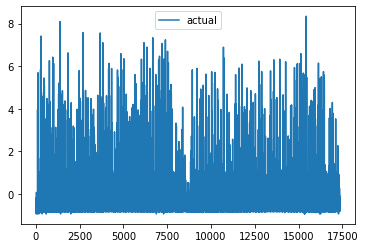

In [35]:
# Visualize original data
plt.plot(actual_data_client, label="actual")
plt.legend()
plt.plot()

[]

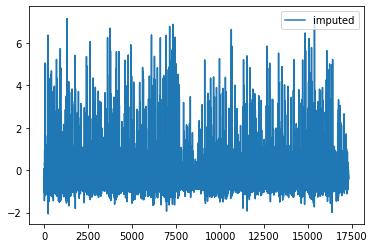

In [36]:
# Visualize original data
plt.plot(imputed_data_client, label="imputed")
plt.legend()
plt.plot()

In [37]:
# Function to store the imputed data
def store_imputed_data(n_users, L, dim, missing_percentage, imputed_data):
    results_path = f"../imputed_data/traffic"
    file_name = f"numuser_{n_users}_L_{L}_dim_{dim}_missingPercentage_{missing_percentage}"
    file_path = os.path.join(results_path, file_name)
    np.save(file_path, imputed_data)

In [38]:
# Store imputed data
store_train = False
if store_train:
    store_imputed_data(n_users=20, L=100, dim=80, missing_percentage=0, imputed_data=imputed_data_flatten_np)

In [39]:
store_test = False
data_test_np = data_test.to_numpy().T
data_test_np.shape

(20, 168)

In [40]:
# Function to store the imputed data
def store_test_data(test_data):
    results_path = f"../test_data/"
    file_name = f"test_traff_data_168steps"
    file_path = os.path.join(results_path, file_name)
    np.save(file_path, test_data)
if store_test:
    store_test_data(data_test_np)